# Assignment 5: Link Analysis

In this assignment, we will use network-based algorithms, such as PageRank, to improve our search results. After the last assignment on evaluating IR systems, we go back to our PubMed dataset of scientific papers. In this dataset, we look at two graphs in particular: the co-authorship network and the citation network.

The citation network is similar to the link network of the web: Citations are like web links pointing to other documents. We can therefore apply the same network-based ranking methods.

## Code from previous assignments

In [2]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100   

In [3]:
Ids_file = 'data/emotion_Ids.pkl.bz2'
Summaries_file = 'data/emotion_Summaries.pkl.bz2'
Citations_file = 'data/emotion_Citations.pkl.bz2'
Abstracts_file = 'data/emotion_Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Citations = pickle.load( bz2.BZ2File( Citations_file, 'rb' ) )
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [4]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    if s.doi != '':
        title = '<a href=http://dx.doi.org/{:s}>{:s}</a>'.format(s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>{:s}</em></small>'.format(Abstracts[id]))
    if (show_id):
        lines.append('[ID: {:d}]'.format(id))
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )

In [5]:
def tokenize(text):
    return text.split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

In [6]:
inverted_index = defaultdict(list)

for id in sorted(Summaries.keys()):
    term_set = set(preprocess(tokenize(Summaries[id].title)))
    if id in Abstracts:
        term_set.update(preprocess(tokenize(Abstracts[id])))
    for term in term_set:
        inverted_index[term].append(id)

tf_matrix = defaultdict(Counter)

for doc_id in Summaries.keys():
    tokens = preprocess(tokenize(Summaries[doc_id].title))
    if (doc_id in Abstracts):
        tokens.extend(preprocess(tokenize(Abstracts[doc_id])))
    tf_matrix[doc_id] = Counter(tokens)

def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))

num_documents = float(len(Summaries))

def idf(t):
    return log10((num_documents + 1)/(df(t) + 1))

def tfidf(t,d):
    return tf(t,d) * idf(t)

## Co-authorship network

We start by building a mapping from authors to the set of identifiers of papers they authored.  We'll be using Python sets again for that purpose.

In [7]:
papers_of_author = defaultdict(set)

for (id, p) in Summaries.items():
    for a in p.authors:
        papers_of_author[a].add(id)

Let's try it out:

In [8]:
papers_of_author['Eriksen HR']

{9309949, 17760288, 31649584}

In [9]:
for id in papers_of_author['Eriksen HR']:
    display_summary(id)

We can now build a co-authorship network, that is a graph linking authors to the set of co-authors they have published with:

In [10]:
coauthors = defaultdict(set)

for p in Summaries.values():
    for a in p.authors:
        coauthors[a].update(p.authors)

# The code above results in each author being listed as having co-authored with himself/herself.
# We remove these self-references here:
for (a, ca) in coauthors.items():
    ca.remove(a)

And let's try it out again:

In [10]:
print(', '.join( coauthors['Eriksen HR'] ))

Marquis P, Jensen C, Grant I, Johansen T, Orre IJ, Ursin H, Svensen E, Olff M, Jakobsen H, Øyeflaten I, Suedfeld P, Palinkas LA, Holsen IN, Dittrich WH, Lyby PS


Unlike a citation or link network, the edges of this co-authorship network are not directed: There is no direction (no arrow) in the link between author 'Eriksen HR' and 'Suedfeld P', for example. With our chosen implementation, each of these links in fact appears twice in our data, as we also get 'Eriksen HR' as co-author when we look for 'Suedfeld P':

In [11]:
print(', '.join( coauthors['Suedfeld P'] ))

Marquis P, Grant I, Orre IJ, Ursin H, Svensen E, Palinkas LA, Eriksen HR


With that in mind, we can calculate some basic statistics about our graph:

In [11]:
print('Number of nodes (authors): ', len(coauthors))

# We divide by two here to account for the fact that each edge is represented twice (see above):
coauthor_rel_count = int(sum( len(c) for c in coauthors.values() ) / 2)
print('Number of links (co-authorship relations): ', coauthor_rel_count)

Number of nodes (authors):  99675
Number of links (co-authorship relations):  590848


With this data at hand, we can plot the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) by showing the number of collaborators a scientist has published with:

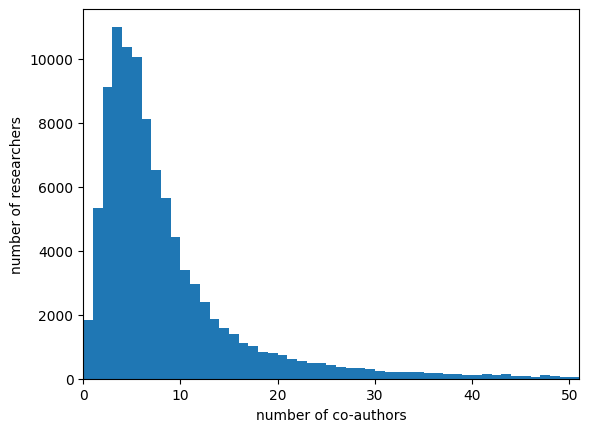

In [12]:
plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(60) )
plt.xlabel('number of co-authors')
plt.ylabel('number of researchers')
plt.xlim(0,51);

Now that we have explored this network, let's move to the citation network.

## Citations network

Next, we can look at the citation network. In contrast to the co-authorship network, the citation network is a _directed_ network, where edges can be drawn as arrows. We'll start by expanding the our data about citations into two mappings: 

* `papers_citing[id]`: papers citing a given paper
* `cited_by[id]`: papers cited by a given paper (in other words: its list of references)

`papers_citing` will give us the list of a node's incoming links, whereas `cited_by` will give us the list of its outgoing links.

In [13]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.items():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

As we are dealing with a subset of the data (the papers mentioning "emotion"), `papers_citing` can contain references to papers outside of our subset. On the other hand, the way we created `cited_by`, it will only contain backward references from within our dataset, meaning that it is incomplete with respect to the whole dataset. Nethertheless, we can use this citation network on our subset of emotion-related papers to implement link analysis techniques.

Let us now look at an exemplary paper, let's say the one with identifier 26784347. We can now use the `cited_by` mapping to retrieve its (incomplete) list of references:

In [14]:
paper_id = 26784347
refs = { id : Summaries[id].title for id in cited_by[paper_id] }
print(len(refs), 'references found for paper', paper_id)
refs

39 references found for paper 26784347


{24708508: 'Judgments of subtle facial expressions of emotion.',
 24388852: 'Dynamic facial expressions of emotion transmit an evolving hierarchy of signals over time.',
 23659578: 'Classification of dynamic facial expressions of emotion presented briefly.',
 22876223: 'Attention and awareness each influence amygdala activity for dynamic bodily expressions-a short review.',
 22131445: 'The resolution of facial expressions of emotion.',
 22081890: 'Introducing the Geneva Multimodal expression corpus for experimental research on emotion perception.',
 21859206: 'Moving faces, looking places: validation of the Amsterdam Dynamic Facial Expression Set (ADFES).',
 20809200: 'Facial emotion recognition in autism spectrum disorders: a review of behavioral and neuroimaging studies.',
 19884144: 'The face is not an empty canvas: how facial expressions interact with facial appearance.',
 19803591: 'Emotion recognition from expressions in face, voice, and body: the Multimodal Emotion Recognition T

If we lookup the same paper in `papers_citing`, we now see that some of the cited papers are themselves in our dataset, but others are not (shown below as `'??'`):

In [15]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{34138924: '??',
 33958630: 'The paradoxical role of emotional intensity in the perception of vocal affect.',
 33930026: 'SUST Bangla Emotional Speech Corpus (SUBESCO): An audio-only emotional speech corpus for Bangla.',
 33053797: 'Recognizing Emotions through Facial Expressions: A Largescale Experimental Study.',
 32804342: 'Human and machine validation of 14 databases of dynamic facial expressions.',
 32170180: 'Perception of Discrete Emotions in Others: Evidence for Distinct Facial Mimicry Patterns.',
 31762947: 'Are you angry at me? Negative interpretations of neutral facial expressions are linked to child maltreatment but not to posttraumatic stress disorder.',
 31258497: 'Development and Validation of Verbal Emotion Vignettes in Portuguese, English, and German.',
 30800085: '??',
 29928240: "Incongruence Between Observers' and Observed Facial Muscle Activation Reduces Recognition of Emotional Facial Expressions From Video Stimuli.",
 29370198: 'Gender differences in emotion perc

Paper 34138924, for example, is not in our dataset and we do not have any direct information about it, but its repeated occurrence in other papers' citation lists does allow us to reconstruct some of its references. Below is the list of papers in our dataset cited by that paper:

In [16]:
paper_id2 = 34138924
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print(len(refs2), 'references identified for the paper with id', paper_id2)
refs2

20 references identified for the paper with id 34138924


{32804342: 'Human and machine validation of 14 databases of dynamic facial expressions.',
 31834900: 'The effect of emotional information from eyes on empathy for pain: A subliminal ERP study.',
 31622426: 'Assessing the convergent validity between the automated emotion recognition software Noldus FaceReader 7 and Facial Action Coding System Scoring.',
 30744534: "Validating the Radboud faces database from a child's perspective.",
 30589868: "Subjective ratings and emotional recognition of children's facial expressions from the CAFE set.",
 30273355: 'Cross-cultural emotion recognition and evaluation of Radboud faces database with an Indian sample.',
 29218587: 'Facial expression analysis with AFFDEX and FACET: A validation study.',
 28553255: 'Development of the Korean Facial Emotion Stimuli: Korea University Facial Expression Collection 2nd Edition.',
 26784347: 'Validation of the Amsterdam Dynamic Facial Expression Set--Bath Intensity Variations (ADFES-BIV): A Set of Videos Expressi

Now that we have a better understanding about the data we're dealing with, let us obtain again some basic statistics about our graph.

In [17]:
n = len(Ids)
print('Number of papers in our subset: {:d} ({:.2f} %)'.format(n, 100.0) )

with_citation = [ id for id in Ids if papers_citing[id] != [] ]
with_citation_rel = 100. * len(with_citation) / n
print('Number of papers cited at least once: {:d} ({:.2f} %)'.format(len(with_citation), with_citation_rel) )

isolated = set( id for id in Ids if papers_citing[id] == [] and id not in cited_by )
isolated_rel = 100. * len(isolated) / n
print('Number of isolated nodes:  {:d} ({:.2f} %)'.format(len(isolated), isolated_rel) )

Number of papers in our subset: 46483 (100.00 %)
Number of papers cited at least once: 35018 (75.34 %)
Number of isolated nodes:  8737 (18.80 %)


In [18]:
id_set = set( Ids )
citing_set = set( cited_by.keys() )

outsiders = citing_set - id_set   # set difference
nodes = citing_set | id_set   # set union
non_isolated = nodes - isolated   # set difference

print('Overall number of nodes: {:d} ({:.2f} %)'.format(len(nodes), 100.0) )

non_isolated_rel = 100. * len(non_isolated) / len(nodes)
print('Number of non-isolated nodes: {:d} ({:.2f} %)'.format(len(non_isolated), non_isolated_rel) )

outsiders_rel = 100. * len(outsiders) / len(nodes)
print('Number of nodes outside our subset: {:d} ({:.2f} %)'.format( len(outsiders), outsiders_rel ) )

Overall number of nodes: 221889 (100.00 %)
Number of non-isolated nodes: 213152 (96.06 %)
Number of nodes outside our subset: 175406 (79.05 %)


In [19]:
all_citations = [ c for citing in papers_citing.values() for c in citing ]
outsider_citations = [ c for citing in papers_citing.values() for c in citing if c in outsiders ]

print('Overall number of links (citations): {:d} ({:.2f} %)'.format(len(all_citations), 100.0) )

outsider_citations_rel = 100. * len(outsider_citations) / len(all_citations)
print('Citations outside the subset: {:d} ({:.2f} %)'.format(len(outsider_citations), outsider_citations_rel) )

Overall number of links (citations): 562891 (100.00 %)
Citations outside the subset: 401831 (71.39 %)


Let us now find our which 10 papers are the most cited in our dataset.

In [20]:
citation_count_per_paper = [ (id, len(citations)) for (id,citations) in papers_citing.items() ]
sorted_by_citation_count = sorted(citation_count_per_paper, key=lambda i:i[1], reverse=True)

for (id, c) in sorted_by_citation_count[:10]:
    display_summary(id, extra_text = 'Citation count: ' + str(c))

Before we can start calculating some interesting network metrics, we will first have a closer look at the Python package that we are going to use for that.

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will use [NetworkX](https://pypi.python.org/pypi/networkx), a Python package for dealing with complex networks:

In [21]:
! pip install --user networkx

In [22]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](https://networkx.org/documentation/stable/reference/algorithms/index.html) and [functions](https://networkx.org/documentation/stable/reference/functions.html) of NetworkX to our graph:

In [23]:
#print(nx.info(G)) //outdated function
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Number of nodes: 213152
Number of edges: 562891
Directed graph: True
Density of graph: 1.2389321369843012e-05


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [24]:
G.add_nodes_from(isolated)

And now we get slightly different values:

In [25]:
#print(nx.info(G)) //outdated function
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Number of nodes: 221889
Number of edges: 562891
Directed graph: True
Density of graph: 1.1432855547712948e-05


Now we are ready to use this package for our tasks.

----------

# Tasks

**Your name:** Aldric de Jacquelin #2711498

### Task 1

Plot the in-degree distribution (that is, the distribution of the number of incoming links; see [here](https://en.wikipedia.org/wiki/Degree_distribution) and [here](http://mathinsight.org/degree_distribution) for more detailed explanations) for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

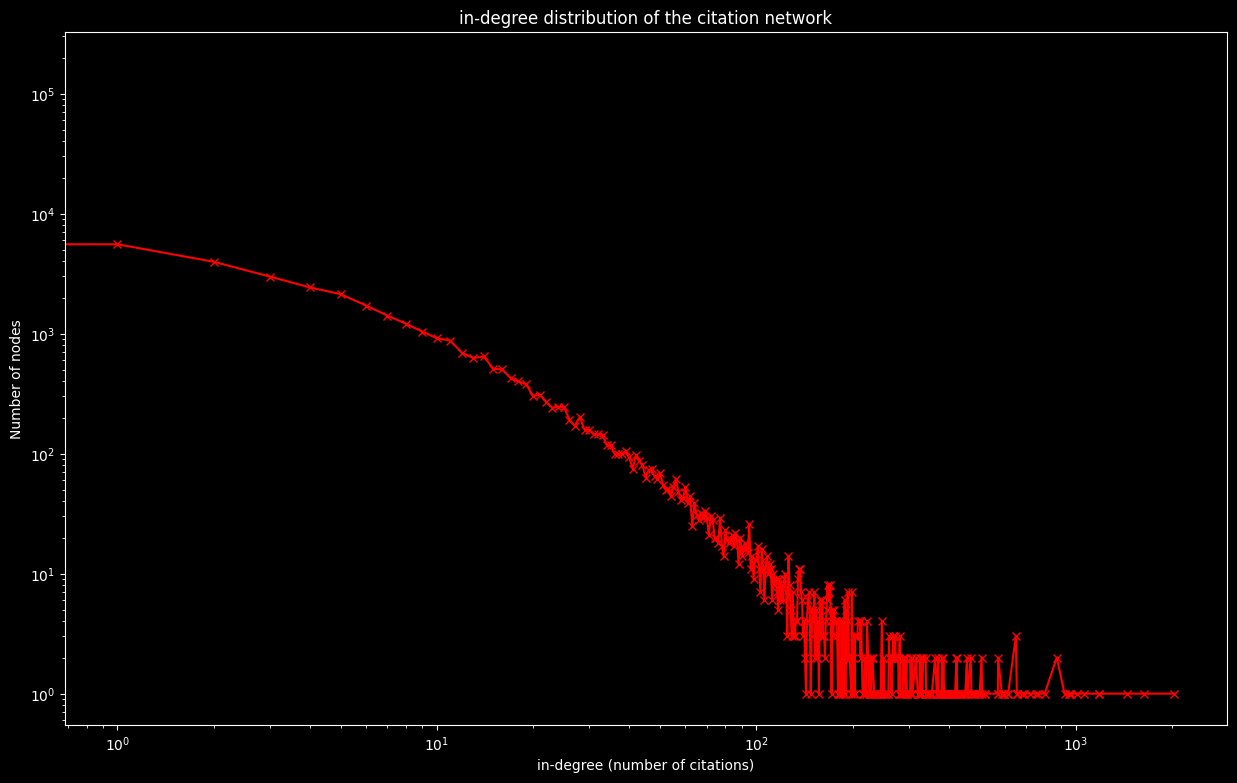

In [26]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from collections import Counter
style.use('dark_background')
# build directed graph from the citation network
G = nx.DiGraph(cited_by)
#calculate in-degree of each node
in_degrees = dict(G.in_degree())  #returns dictionary with node_id: in_degree
#range the in-degree values for plotting
in_degree_values = sorted(set(in_degrees.values()))
in_degree_histogram = [list(in_degrees.values()).count(x) for x in in_degree_values]

plt.figure(figsize=(15, 9))
plt.loglog(in_degree_values, in_degree_histogram, 'rx-')
plt.title('in-degree distribution of the citation network')
plt.xlabel('in-degree (number of citations)')
plt.ylabel('Number of nodes')
plt.show()

**Answer:** 
The in-degree distribution of the citation network seems to follow a power-law, indicating that a few highly cited papers (hubs) significantly influence the network, while most have few citations. This scale-free network is characterized by a lack of characteristic size, allowing indefinite growth, and displays a high degree of heterogeneity due to the variance in connectivity among papers. The network's resilience to random failures can be attributed to its robustness, as it does not rely on the hubs to maintain its overall structure. However, it is vulnerable to targeted removals of these highly connected nodes. The presence of preferential attachment suggests that papers with many citations are more likely to receive more, supporting a "rich get richer" dynamic. Such features are typical in real-world networks and reflect the non-random nature of the network's growth and its dependency on the interconnectedness and dynamics of its nodes.


### Task 2

Using the [Link Analysis](https://networkx.org/documentation/stable/reference/algorithms/link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for all nodes in the citation network, and store the result in a variable called `pageranks`.

To test this, create first a list of all papers that are cited by exactly 10 other papers (using `papers_citing` defined above). Then sort these papers by their PageRank and retrieve the paper IDs with the maximum and minimum PageRank values. Print these minimum and maximum PageRank values together with their paper IDs.

To print PageRank values, you might want to use commands like `print('{:.6f}'.format(var))` to use regular decimal notation with a fixed number of decimal places.

In [27]:
pageranks = nx.pagerank(G)
papers_with_10_citations = [paper for paper, citations in papers_citing.items() if len(citations) == 10]
papers_with_10_citations.sort(key=lambda paper: pageranks[paper])

min_pagerank_paper = papers_with_10_citations[0]
max_pagerank_paper = papers_with_10_citations[-1]

print(f"doc_id min PageRank: {min_pagerank_paper}, PageRank:{pageranks[min_pagerank_paper]:.9f}")
print(f"doc_id max Pagerank: {max_pagerank_paper}, PageRank:{pageranks[max_pagerank_paper]:.9f}")


doc_id min PageRank: 28402574, PageRank:0.000003134
doc_id max Pagerank: 12382205, PageRank:0.000039480


### Task 3

Why do the two papers above have such different PageRank values? Write code below to investigate and show the cause of this, and then explain the cause of this difference based on the results generated by your code.

doc_id min PageRank: 28402574, PageRank:0.000003134
Citing docs for min PageRank paper:
	Citing doc_id: 30934877| PageRank: 0.000007145
	Citing doc_id: 31431608| PageRank: 0.000005151
	Citing doc_id: 29524099| PageRank: 0.000004216
	Citing doc_id: 31863185| PageRank: 0.000003122
	Citing doc_id: 32452461| PageRank: 0.000002678
	Citing doc_id: 30321093| PageRank: 0.000002596
	Citing doc_id: 30971906| PageRank: 0.000002577
	Citing doc_id: 34252137| PageRank: 0.000002430
	Citing doc_id: 33588323| PageRank: 0.000002430
	Citing doc_id: 29428771| PageRank: 0.000002430
doc_id max Pagerank: 12382205, PageRank:0.000039480
Citing docs for max PageRank paper:
	Citing doc_id: 23719209| PageRank: 0.000041656
	Citing doc_id: 20141277| PageRank: 0.000034923
	Citing doc_id: 24139694| PageRank: 0.000002430
	Citing doc_id: 23890734| PageRank: 0.000002430
	Citing doc_id: 22848043| PageRank: 0.000002430
	Citing doc_id: 22537725| PageRank: 0.000002430
	Citing doc_id: 22307637| PageRank: 0.000002430
	Citing 

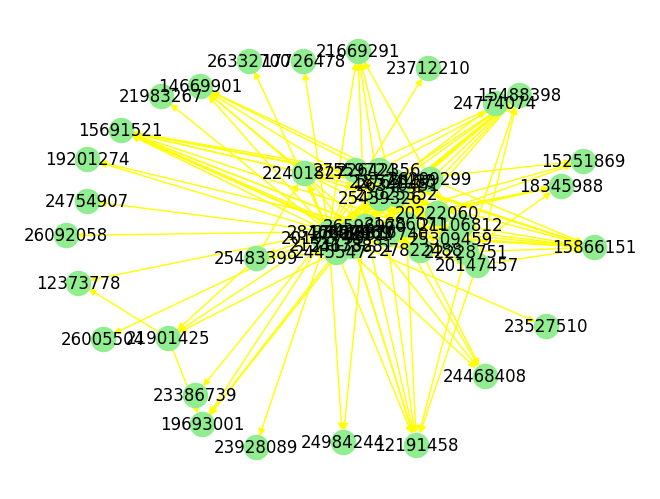

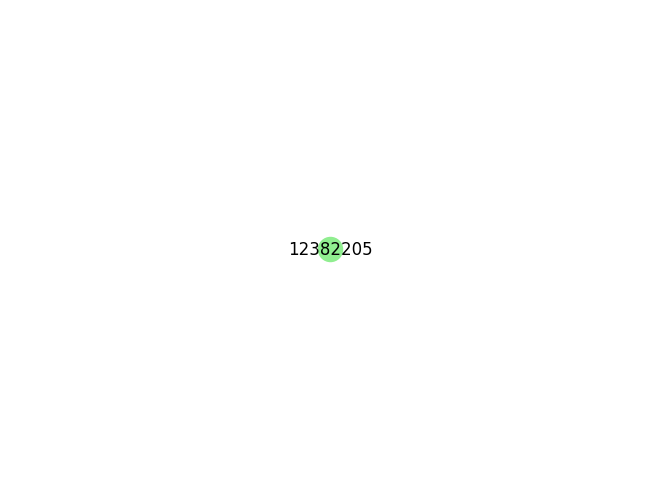

In [28]:
def analyze_citing_papers(paper_id, pageranks):
    citing_papers = papers_citing.get(paper_id, [])
    citing_papers_pagerank = [(cp, pageranks[cp]) for cp in citing_papers]
    citing_papers_pagerank.sort(key=lambda x: x[1], reverse=True)
    return citing_papers_pagerank

min_paper_citing_analysis = analyze_citing_papers(min_pagerank_paper, pageranks)
max_paper_citing_analysis = analyze_citing_papers(max_pagerank_paper, pageranks)

print(f"doc_id min PageRank: {min_pagerank_paper}, PageRank:{pageranks[min_pagerank_paper]:.9f}")
print("Citing docs for min PageRank paper:")
for cp, pr in min_paper_citing_analysis:
    print(f"\tCiting doc_id: {cp}| PageRank: {pr:.9f}")

print(f"doc_id max Pagerank: {max_pagerank_paper}, PageRank:{pageranks[max_pagerank_paper]:.9f}")
print("Citing docs for max PageRank paper:")
for cp, pr in max_paper_citing_analysis:
    print(f"\tCiting doc_id: {cp}| PageRank: {pr:.9f}")

def visualize_subgraph(paper_id, depth=1):
    subgraph_nodes = set([paper_id])
    for _ in range(depth):
        new_nodes = set()
        for node in subgraph_nodes:
            new_nodes.update(cited_by.get(node, []))
        subgraph_nodes.update(new_nodes)
    subgraph = G.subgraph(subgraph_nodes)
    nx.draw(subgraph, with_labels=True, node_color='lightgreen', edge_color='yellow')
    plt.show()

visualize_subgraph(min_pagerank_paper)
visualize_subgraph(max_pagerank_paper)



**Answer:** 
The papers that cite the "max PageRank paper" have higher individual PageRank scores than those citing the "min PageRank paper".This suggests that the "max PageRank paper" is being cited by more authoritative or influential papers within the network, which is a crucial factor in increasing its PageRank. PageRank operates on the principle that a paper is considered important if it is cited by other important papers.
The visualization (which cannot be analyzed in detail due to the limitations of the current environment) likely shows the structure of the citation network around one of the papers. If it represents the "max PageRank paper," we might see that it's more centrally located in a dense network of citations, indicating it's part of a highly interconnected community of research. In contrast, the "min PageRank paper" might occupy a more peripheral position or be part of a sparser subgraph, receiving citations from less-connected papers.
The difference in PageRank is then not only due to the number of citations but also their quality and the structure of the network around each paper. A paper with citations from highly ranked papers or from a dense sub-community within the larger citation network will have a higher PageRank score. The interconnected nature of citations can lead to a compounding effect on PageRank, where a citation from a highly ranked paper can substantially increase the score, more so than several citations from low-ranked papers.


### Task 4

Copy the scoring function `score_ntn_nnn` from Task 4 of assignment 3. Rename it to `score_ntn_nnn_pagerank` and change its code to incorporate a paper's PageRank score in it's final score, in addition to tf-idf. In other words, the new function should accept a `list` of query tokens and a document ID, and should return a single `float` value that is calculated based on both scores (PageRank and tf-idf). Note that a `tf-idf` function is already provided above. Explain your decision on how to combine the two scores.

In [33]:
def idf(t):
    return log10((num_documents + 1) / (df(t) + 1))

def tfidf(t, d):
    return tf(t, d) * idf(t)

def or_merge(sorted_list1, sorted_list2):
    merged_list = []
    list1 = list(sorted_list1)
    list2 = list(sorted_list2)
    while True:
        if not list1:
            merged_list.extend(list2)
            break

        if not list2:
            merged_list.extend(list1)
            break

        if list1[0] < list2[0]:
            merged_list.append(list1[0])
            list1.pop(0)
        elif list1[0] > list2[0]:
            merged_list.append(list2[0])
            list2.pop(0)
        else:
            merged_list.append(list1[0])
            list1.pop(0)
            list2.pop(0)

    return merged_list

def score_ntn_nnn(query_words, doc_id):
    score = 0
    for t in query_words:
        score += tfidf(t, doc_id)
    return score

def query_ntn_nnn(query_string):
    query_words = preprocess(tokenize(query_string))
    first_word = query_words[0]
    remaining_words = query_words[1:]
    or_list = inverted_index[first_word]
    for t in remaining_words:
        or_list = or_merge(or_list, inverted_index[t])

    for paper_id in sorted(or_list, key=lambda i: score_ntn_nnn(query_words, i), reverse=True)[:10]:
        paper = Summaries[paper_id]
        print(str(paper_id) + ' ' + paper.title + ' (score: ' + str(score_ntn_nnn(query_words, paper_id)) + ')')


def score_ntn_nnn_pagerank(query_tokens, doc_id, pageranks, pagerank_weight=0.5):
    tfidf_score = sum(tfidf(t, doc_id) for t in query_tokens)
    pagerank_score = pageranks.get(doc_id, 0)  
    
    score = (1 - pagerank_weight) * tfidf_score + pagerank_weight * pagerank_score
    return score

def query_ntn_nnn_pagerank(query_string, pageranks, pagerank_weight=0.5):
    query_tokens = preprocess(tokenize(query_string))
    first_word = query_tokens[0]
    remaining_words = query_tokens[1:]
    or_list = inverted_index[first_word]
    
    for t in remaining_words:
        or_list = or_merge(or_list, inverted_index[t])

    for paper_id in sorted(or_list, key=lambda i: score_ntn_nnn_pagerank(query_tokens, i, pageranks, pagerank_weight), reverse=True)[:10]:
        paper = Summaries[paper_id]
        score = score_ntn_nnn_pagerank(query_tokens, paper_id, pageranks, pagerank_weight)
        print(f"{paper_id} {paper.title} (score: {score:.4f})")


query = "neural network"
query_ntn_nnn_pagerank(query, pageranks)


28453543 Altered resting-state intra- and inter- network functional connectivity in patients with persistent somatoform pain disorder. (score: 8.4984)
33786029 Modeling, simulation, and case analysis of COVID-19 over network public opinion formation with individual internal factors and external information characteristics. (score: 8.4984)
32618060 Network level characteristics in the emotion recognition network after unilateral temporal lobe surgery. (score: 8.2552)
34527046 Music Waveform Analysis Based on SOM Neural Network and Big Data. (score: 7.5043)
25855888 Processing of different types of social threat in shyness: Preliminary findings of distinct functional neural connectivity. (score: 7.2825)
25803596 Cognitive network neuroscience. (score: 7.0820)
32273568 The role of attention in the relationship between early life stress and depression. (score: 7.0606)
34527043 Music Emotion Analysis Based on PSO-BP Neural Network and Big Data Analysis. (score: 7.0393)
30124815 Reappraisal 

**Answer:** 
 the decision to employ a weighted linear combination for merging tf-idf and PageRank scores stems from the need to balance relevance and authority in document retrieval, the flexibility provided by the weighting parameter, and the practical considerations of implementation and performance. This approach strikes a balance between ensuring document relevance to the user's query and identifying documents that hold significance within the scientific community.


### Task 5

Copy the query function `query_ntn_nnn` from Task 4 of assignment 3 (also copy `or_merge`). Rename it to `query_ntn_nnn_pagerank` and change the code to use our new scoring function `score_ntn_nnn_pagerank` from task 4 above. Demonstrate these functions with an example query that returns paper 11244481 as the top result.

In [54]:
def query_ntn_nnn_pagerank(query_string, pageranks, pagerank_weight=0.5):
    query_tokens = preprocess(tokenize(query_string))
    first_word = query_tokens[0]
    remaining_words = query_tokens[1:]
    or_list = inverted_index[first_word]
    
    for t in remaining_words:
        or_list = or_merge(or_list, inverted_index[t])

    results = []
    for paper_id in sorted(or_list, key=lambda i: score_ntn_nnn_pagerank(query_tokens, i, pageranks, pagerank_weight), reverse=True)[:10]:
        paper = Summaries[paper_id]
        score = score_ntn_nnn_pagerank(query_tokens, paper_id, pageranks, pagerank_weight)
        results.append((paper_id, paper.title, score))
    
    return results


desired_query = "science health"
desired_paper_id = 11244481

results = query_ntn_nnn_pagerank(desired_query, pageranks)

found_paper = None
for result in results:
    if result[0] == desired_paper_id:
        found_paper = result
        break
    
if found_paper:
    paper_id, paper_title, score = found_paper
    print(f"Paper ID: {paper_id}")
    print(f"Title: {paper_title}")
    print(f"Score: {score:.4f}")
else:
    print(f"Paper with ID {desired_paper_id} not found in the results for the query '{desired_query}'")

Paper with ID 11244481 not found in the results for the query 'science health'


# Submission

Submit the answers to the assignment via Canvas as a modified version of this Notebook file (file with `.ipynb` extension) that includes your code and your answers.

Before submitting, restart the kernel and re-run the complete code (**Kernel > Restart & Run All**), and then check whether your assignment code still works as expected.

Don't forget to add your name, and remember that the assignments have to be done **individually**, and that code sharing or copying are **strictly forbidden** and will be punished.